<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance3_Equipo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

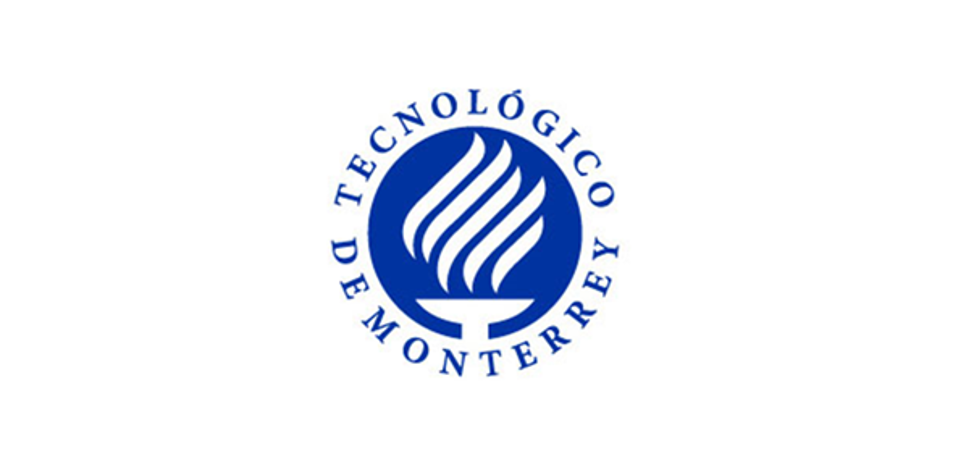

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

###Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



###Prof. Titulares:
###Dra. Grettel Barceló Alonso
###Dr. Luis Eduardo Falcón Morales



###Avance 3. Base Lin.



###EQUIPO 2
###Alumnos - Matrícula
###**Matthias Sibrian Illescas - A01794249**
###**José Ramiro Adán Charles - A00174646**
###**Genaro Ramos Higuera - A00351269**



## ARQUITECTURA

Basado en la arquitectura genérica RETRIEVER-READER.

Usando la herramienta **Haystack** para validación del modelo de lenguage de **Hugging Face Hub** llamado "**dccuchile/albert-base-spanish-finetuned-qa-mlqa**" en su aplicabilidad de extraer respuestas acertadas del tipo de información que representa la normatividad académica.

## NOTAS PARA EJECUCION EN COLAB

Aunque corre sin GPU, es recomendable activarlo si esta disponible.

## Instalar Haystack

In [1]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,inference]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Puede ser necesario reiniciar después de instalar el siguiente

In [2]:
!pip install farm-haystack[elasticsearch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 816.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


Set the logging level to INFO:

In [3]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## Preparar fuente de datos

####Crear data/pdf
####Crear data/txt
####Crear data/txt_norm para guardar archivos con texto normalizado (pruebas)
####Crear data/txt_raw para guardar archivos con texto sin pre procesamiento
####Copiar PDFs en data/pdf
####Usar libreria PyPDF2 para extraer texto de archivos

In [4]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.1 MB/s eta 0:00:00


## Extrayendo texto de PDF y guardarlos como archivos txt


In [7]:
import os
import PyPDF2

# Carpeta donde se encuentran los PDFs
carpeta_pdf = "/content/data/pdf"
carpeta_txt = "/content/data/txt"

# Recorre cada archivo PDF en la carpeta
for archivo in os.listdir(carpeta_pdf):
#    if archivo.endswith("Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf"):
    if archivo.endswith(".pdf"):
        # Extrae el nombre del archivo sin la extensión
        nombre_archivo, _ = os.path.splitext(archivo)

        # Abre el archivo PDF en modo lectura binaria
        with open(os.path.join(carpeta_pdf, archivo), 'rb') as pdf_file:
            # Crea un lector de PDF
            lector = PyPDF2.PdfReader(pdf_file)

            # Extrae el texto de cada página
            texto = ""
            texto_extraido = ""
            texto_raw = ""
            for pagina in lector.pages:
                # Extrae el texto de la página
                texto_pagina = pagina.extract_text()
                texto_raw += texto_pagina
                #texto_pagina_no_guiones = texto_pagina.replace('-\n', '').replace(' - \n', '').replace(' -\n', '').replace('- \n', '').replace('-  \n', '')
                texto_pagina_no_guiones = texto_pagina.replace(' -\n', '')

                # Juntar palabras incompletas por guiones
                palabras_sin_guiones = []
                palabra_actual = ""
                for caracter in texto_pagina_no_guiones:
                  if caracter == "-":
                    if palabra_actual:
                      palabras_sin_guiones.append(palabra_actual)
                    palabra_actual = ""
                  else:
                    palabra_actual += caracter

                if palabra_actual:
                  palabras_sin_guiones.append(palabra_actual)

                texto_pagina_sin_guiones = " ".join(palabras_sin_guiones)
                texto_extraido += texto_pagina_sin_guiones

#            texto_normalizado = clean_text(texto_extraido)

            # Guarda el texto en un archivo de texto con el nombre original
            with open(carpeta_txt + '/' + f"{nombre_archivo}.txt", "w", encoding="utf-8") as archivo_txt:
                archivo_txt.write(texto_extraido)
            # Guarda el texto raw en un archivo de texto con el nombre original
            with open(carpeta_txt + '_raw/' + f"{nombre_archivo}.txt", "w", encoding="utf-8") as archivo_txt:
                archivo_txt.write(texto_raw)

## Inicializar DocumentStore

Iniciamos creando el sistema de respuestas-a-preguntas inicializando DocumentStore.


In [8]:
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore(use_bm25=True)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems in the [documentation page](https://docs.haystack.deepset.ai/docs/telemetry#how-can-i-opt-out). More information at [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry).
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


##Indexar informacion de archivos txt

In [9]:
from haystack import Pipeline
from haystack.nodes import TextConverter, PreProcessor

indexing_pipeline = Pipeline()
text_converter = TextConverter()
preprocessor = PreProcessor(
    clean_whitespace=False,
    clean_header_footer=False,
    clean_empty_lines=True,
    split_by="word",
    split_length=200,
    split_overlap=20,
    split_respect_sentence_boundary=False,
)
#    language='es',

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
import os

indexing_pipeline.add_node(component=text_converter, name="TextConverter", inputs=["File"])
indexing_pipeline.add_node(component=preprocessor, name="PreProcessor", inputs=["TextConverter"])
indexing_pipeline.add_node(component=document_store, name="DocumentStore", inputs=["PreProcessor"])

files_to_index = [carpeta_txt + "/" + f for f in os.listdir(carpeta_txt)]
indexing_pipeline.run_batch(file_paths=files_to_index)

INFO:haystack.pipelines.base:It seems that an indexing Pipeline is run, so using the nodes' run method instead of run_batch.
Preprocessing: 100%|██████████| 187/187 [00:01<00:00, 99.10docs/s] 
INFO:haystack.document_stores.base:Duplicate Documents: Document with id 'f9ada1b77d0e5e174bd6b8b6c3d0bdb2' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id 'c009420d007ce5b809f03fdbeb4ad1ea' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '5f55da095bf716ba1ef4b007aa13204a' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '432f7e52b0e65b8c132abcc18151140a' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id 'eadec48c618c0f298844f98dbb20022e' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id 'ba52c8d9e20f160a50

{'documents': [<Document: {'content': 'REGULATIONS ON SCHOLARSHIPS AND \nSTUDENT LOANS FOR HIGH SCHOOL \nAND UNDERGRADUATE STUDENTS \nINSTITUTO TECNOLÓGICO Y DE ESTUDIOS\nSUPERIORES DE MONTERREY\nPromulgation date:  Agosto de 2014  \nAmendmen: 2015, 2016, 2017, 2018, 2019\nD.R. © Instituto Tecnológico y de Estudios Superiores de Monterrey. \nAve. Eugenio Garza Sada 2501 Sur, Col. Tecnológico C.P. 64849, Monterrey, N.L., México.\nNo part of this document may be reproduced in any form or by any means without the prior express \nwritten consent of Instituto Tecnológico y de Estudios Superiores de Monterrey for any person or \nactivity that is unrelated to the same.Notice on the use of inclusive language\nThe use of the generic masculine or masculine of a collective nature seeks to sim \nplify communication in consideration of the principle of economy of language. Gram \nmatical gender (masculine, feminine) is normally associated with biological sex; \nhowever, grammatically there is no in

In [11]:
import os
from haystack.pipelines.standard_pipelines import TextIndexingPipeline

files_to_index = [carpeta_txt + "/" + f for f in os.listdir(carpeta_txt)]
indexing_pipeline = TextIndexingPipeline(document_store)
indexing_pipeline.run_batch(file_paths=files_to_index)

INFO:haystack.pipelines.base:It seems that an indexing Pipeline is run, so using the nodes' run method instead of run_batch.
Preprocessing: 100%|██████████| 187/187 [00:02<00:00, 70.75docs/s]
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '4ad3cbb40078c8581d414b0092825169' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id 'dd962686057f0e28b96dcd1840f4b7e9' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '9100a15939b1a7b2159aa003eeac3603' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '3c829769c13d88276520d19f5970da71' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '6771fbf1cb244eb83a03e7dc20e21c0e' already exists in index 'document'
INFO:haystack.document_stores.base:Duplicate Documents: Document with id '5d2a46d38b070d11b77

{'documents': [<Document: {'content': 'REGULATIONS ON SCHOLARSHIPS AND\nSTUDENT LOANS FOR HIGH SCHOOL\nAND UNDERGRADUATE STUDENTS\nINSTITUTO TECNOLÓGICO Y DE ESTUDIOS\nSUPERIORES DE MONTERREY\nPromulgation date:  Agosto de 2014\nAmendmen: 2015, 2016, 2017, 2018, 2019\nD.R. © Instituto Tecnológico y de Estudios Superiores de Monterrey.\nAve. Eugenio Garza Sada 2501 Sur, Col. Tecnológico C.P. 64849, Monterrey, N.L., México.\nNo part of this document may be reproduced in any form or by any means without the prior express\nwritten consent of Instituto Tecnológico y de Estudios Superiores de Monterrey for any person or\nactivity that is unrelated to the same.Notice on the use of inclusive language\nThe use of the generic masculine or masculine of a collective nature seeks to sim\nplify communication in consideration of the principle of economy of language. Gram\nmatical gender (masculine, feminine) is normally associated with biological sex;\nhowever, grammatically there is no intention to 

## Inicializamos el Retriever

Utilizamos el algoritmo BM25 y lo inicializamos para utilizarlo con InMemoryDocumentStore, para que el Retriever pueda encontrar los documentos más relevantes.

In [12]:
from haystack.nodes import BM25Retriever

retriever = BM25Retriever(document_store=document_store)

## Inicializar el Reader

El READER buscará textos recibidos del RETRIEVER y extraerá los candidatos más coinicidentes para lo cual usará FARMReader con el modelo de pregunta-respuesta de Hugging Face llamado "dccuchile/albert-base-spanish-finetuned-qa-mlqa".

In [13]:
from haystack.nodes import FARMReader

#reader = FARMReader(model_name_or_path="dccuchile/bert-base-spanish-wwm-uncased-finetuned-qa-mlqa", use_gpu=True)
reader = FARMReader(model_name_or_path="dccuchile/albert-base-spanish-finetuned-qa-mlqa", use_gpu=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'dccuchile/albert-base-spanish-finetuned-qa-mlqa' (Albert)


pytorch_model.bin:   0%|          | 0.00/44.9M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Auto-detected model language: spanish
INFO:haystack.modeling.model.language_model:Loaded 'dccuchile/albert-base-spanish-finetuned-qa-mlqa' (Albert model) from model hub.


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


## Creacion del Pipeline Retriever-Reader


In [14]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

Ya está listo el Pipeline para las preguntas.

## Probar haciendo una pregunta
y ver los Score (de confianza) de las respuestas

In [17]:
#prediction = pipe.run(
 #   query="¿Que es el período sabático?", params={"Retriever": {"top_k": 15}, "Reader": {"top_k": 5}}
#)
prediction = pipe.run(
    query="¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)
#prediction = pipe.run(
#  query="¿Cuál es la calificación aprobatoria en nivel Posgrado?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
#)
#prediction = pipe.run(
#  query="¿Para qué niveles de estudio aplican los Lineamientos de Credenciales Alternativas?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
#)
#prediction = pipe.run(
#  query="¿Cuáles son los correos más recientes sobre créditos?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
#)
from pprint import pprint

pprint(prediction)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.23 Batches/s]

{'answers': [<Answer {'answer': '80', 'type': 'extractive', 'score': 0.7563717365264893, 'context': 'ecnológico de\nMonterrey.\n17. Se amplía en el Artículo 79, la definición de crédito académico\npara incluir a preparatoria, y su secuencia cambia a 80.\n', 'offsets_in_document': [{'start': 1266, 'end': 1268}], 'offsets_in_context': [{'start': 146, 'end': 148}], 'document_ids': ['41071bd6e60da1a119c4174ee1c3dede'], 'meta': {'_split_id': 104}}>,
             <Answer {'answer': '15 horas de sesiones con el \nprofesor más 39 horas de trabajo independiente del estudiante, lo cual son 54 horas \nen total durante el periodo académico .', 'type': 'extractive', 'score': 0.5118885040283203, 'context': ' 15 horas de sesiones con el \nprofesor más 39 horas de trabajo independiente del estudiante, lo cual son 54 horas \nen total durante el periodo académico .', 'offsets_in_document': [{'start': 613, 'end': 766}], 'offsets_in_context': [{'start': 1, 'end': 154}], 'document_ids': ['f9ada1b77d0e5e174

Ahora vemos las top respuestas

In [18]:
from haystack.utils import print_answers

print_answers(prediction, details="all")  ## Choose from `minimum`, `medium`, and `all`

('Query: ¿Cuál es la definición exacta de un crédito académico en nuestra '
 'institución para los 3 niveles Preparatoria, Profesional y Posgrado?')
'Answers:'
[   <Answer {'answer': '80', 'type': 'extractive', 'score': 0.7563717365264893, 'context': 'ecnológico de\nMonterrey.\n17. Se amplía en el Artículo 79, la definición de crédito académico\npara incluir a preparatoria, y su secuencia cambia a 80.\n', 'offsets_in_document': [{'start': 1266, 'end': 1268}], 'offsets_in_context': [{'start': 146, 'end': 148}], 'document_ids': ['41071bd6e60da1a119c4174ee1c3dede'], 'meta': {'_split_id': 104}}>,
    <Answer {'answer': '15 horas de sesiones con el \nprofesor más 39 horas de trabajo independiente del estudiante, lo cual son 54 horas \nen total durante el periodo académico .', 'type': 'extractive', 'score': 0.5118885040283203, 'context': ' 15 horas de sesiones con el \nprofesor más 39 horas de trabajo independiente del estudiante, lo cual son 54 horas \nen total durante el periodo académico 

Podemos ver en la primera respuesta tenemos un score de confianza del 75.6%.

La segunda respuesta nos da un score de confianza del 51%.


#CONCLUSION

Este es un modelo base inicial con el que estamos arrancando, que nos entrega respuestas con un nivel de coherencia aceptable segun los scores de confianza resultantes, y por supuesto susceptible de mejorar y que deberá de someterse a una evaluacion u opinión del responsable funcional del área de politicas y normativa del Tec de Monterrey.